In [1]:
# Importieren von Bibliotheken
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

import numpy as np
from matplotlib import pyplot as plt

In [2]:
########################################### Funktionen ############################################################################################

def kinetic (circuit, phi):     # Gates zur Simulation der Zeitentwicklung durch H_0
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden

    for i in range(n):
        circuit.p(-phi*2**(i+1),i+1)
        for j in range(i+1,n):
            circuit.cx(j+1,0)
            circuit.cx(i+1,0)
            circuit.p(-phi*2**(i+j+1),0)
            circuit.cx(i+1,0)
            circuit.cx(j+1,0)

    return circuit

def timeEv (circuit, q, phi, iterations):      # Zeitentwicklung
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden
    for i in range(iterations):
        circuit.append(QFT(n), q[1:])
        kinetic(circuit=circuit, phi=phi)
        circuit.append(QFT(n, inverse=True), q[1:])

    return circuit

In [3]:
########################################### Startparameter ########################################################################################

n = 6   # Anzahl Qubits
N = 2**n    # Anzahl Gitterpunkte
m = 1000       # Massenfaktor des Teilchens

phi = 0.005/2
phi = phi/4/m     # Phasenfaktor

# Ortsraumgitter
x_min = -2
x_max = 2
x = np.linspace(x_min, x_max, num=N)

# Gaußsches Wellenpaket als Anfangszustand
mu=0
sigma = 0.2
psi= np.sqrt(1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(0.5*(x-mu)**2)/(sigma**2)))
psi/= np.sqrt(np.sum(np.abs(psi**2)))       # Normierung auf 1

#plt.plot(x, np.sqrt(psi))

In [4]:
########################################### Simulation ############################################################################################

q = QuantumRegister(n+1)    # Erzeugen eines Quantenregisters mit zusätzlichem ancilla-Qubit
c = ClassicalRegister(n)    # Erzeugen eines klassichen Registers, in dem die gemessenen Zustände gespeichert werden
circuit = QuantumCircuit(q,c)   # Erstellen eines circuits

# Initialisierung des Anfangszustandes
circuit.initialize(psi,q[1:])

simulator = Aer.get_backend('qasm_simulator')   # Festlegen des Simulators, der genutzt werden soll

timeev = []     # Array, in dem die Zwischenschritte gespeichert werden

# Speichern der Anfangsverteilung
temp = circuit.copy()       # temporärer circuit, dessen Endzustand gemessen wird, um Zustandsfunktion von circuit nicht durch Messung zu kollabieren
for j in range(1,n+1):
    temp.measure(j,j-1)
counts = simulator.run(transpile(temp, simulator), shots=5000).result().get_counts()
timeev.append(counts)

# Zeitentwicklung und Messen der Häufigkeitsverteilungen
it = 10
rg = 3      # Anzahl der Durchläufe mit it Iterationen, pro Durchlauf wird die Häufigkeitsverteilung gespeichert

for i in range (rg):
    timeEv(circuit=circuit, q=q, phi=phi, iterations=it)
    temp = circuit.copy()
    for j in range(1,n+1):
        temp.measure(j,j-1)
    counts = simulator.run(transpile(temp, simulator), shots=5000).result().get_counts()
    timeev.append(counts)

In [5]:
########################################### Plots ################################################################################################

# Modifikation, damit im Histogramm auch die Zustände ohne Einträge angezeigt werden
cdata = np.empty((rg+1, N))     # Array, in dem die counts sortiert gespeichert werden

for i in range(N):
  bin = format(i, '0'+str(n)+'b')

  for j in range(len(timeev)):
    if bin not in timeev[j].keys():
      timeev[j][bin] = 0
      cdata[j][i] = 0
    else:
      cdata[j][i] = timeev[j][bin]

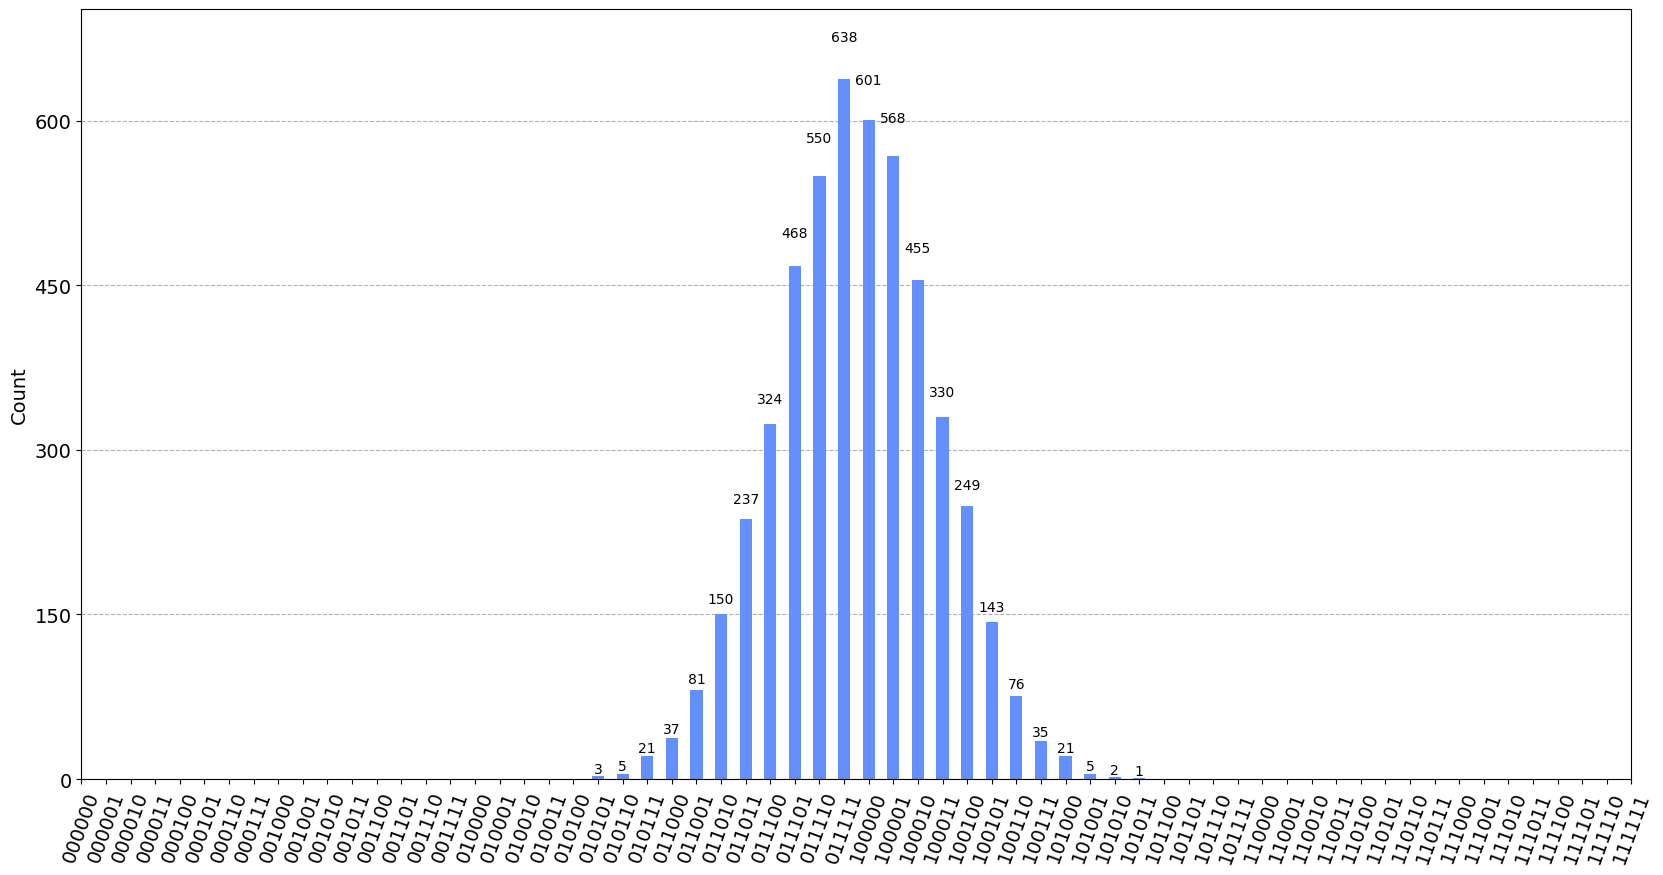

In [6]:
plot_histogram(timeev[0], figsize=[20,10])    # Anzeigen der Histogramme
#plot_histogram(timeev[0], figsize = [20,10], filename='timeev_gauss1_m10.jpg')   # Speichern der Histogramme 

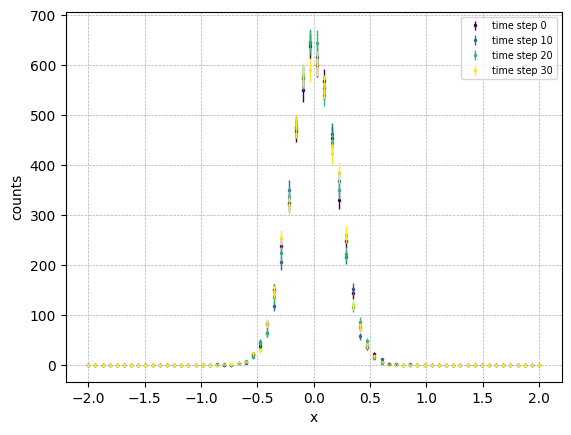

In [8]:
########################################### Plot Klassischer Grenzfall #############################################################################

# Massenfaktor m des Teilchens muss in den Startbedingungen erhöht werden um kl. Grenzfall zu zeigen, z.B. auf m=1000

colors = plt.cm.viridis(np.linspace(0,1,rg+1))

for i in range(len(timeev)):
    plt.errorbar(x, cdata[i], yerr=np.sqrt(cdata[i]), elinewidth=1, barsabove=True, marker='.', markersize=3, color=colors[i], linestyle=' ', label='time step ' + str(i*it))
plt.xlabel('x')
plt.ylabel('counts')
plt.legend(loc='upper right', fontsize='x-small')
plt.grid(linestyle='--', linewidth=0.5)

#plt.savefig('timeev_gauss_klassischer_grenzfall.jpg', bbox_inches="tight",dpi=300)